#### Lab 8
#### На основе ШАД Яндекс


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch

### 1. Нахождение сложной производной

Найдите производную по x от функции 
$$\sin\left(\tan(x)\frac{x^2}{y} + \ln(e^{-x^2 + 3}+x^3y)\right)\tan(x^2e^{x^9})$$

При этом надо пользоваться встроенным в PyTorch autograd. Численное вычисление производной может не дать нужный результат.

In [2]:
def find_x_derivative(x, y):
    # YOUR CODE HERE
    z = torch.sin(torch.tan(x.pow(2)/y)+torch.log(torch.exp(x.pow(2)*1/y+3)+x.pow(3)*y)*torch.tan(x.pow(2)*torch.exp(x.pow(9))))
    z.backward(y)
    return x.grad# YOUR CODE HERE

x = torch.linspace(0.1, 0.01, 100,requires_grad=True)
y = torch.linspace(0.1, 0.1, 100)
#print(x)
print(find_x_derivative(x, y))

tensor([0.2637, 0.2613, 0.2588, 0.2564, 0.2539, 0.2515, 0.2490, 0.2466, 0.2441,
        0.2417, 0.2392, 0.2368, 0.2343, 0.2319, 0.2294, 0.2270, 0.2246, 0.2221,
        0.2197, 0.2173, 0.2148, 0.2124, 0.2100, 0.2075, 0.2051, 0.2027, 0.2003,
        0.1978, 0.1954, 0.1930, 0.1906, 0.1882, 0.1857, 0.1833, 0.1809, 0.1785,
        0.1761, 0.1737, 0.1713, 0.1689, 0.1665, 0.1641, 0.1617, 0.1592, 0.1568,
        0.1544, 0.1520, 0.1496, 0.1472, 0.1449, 0.1425, 0.1401, 0.1377, 0.1353,
        0.1329, 0.1305, 0.1281, 0.1257, 0.1233, 0.1209, 0.1186, 0.1162, 0.1138,
        0.1114, 0.1090, 0.1066, 0.1043, 0.1019, 0.0995, 0.0971, 0.0947, 0.0924,
        0.0900, 0.0876, 0.0852, 0.0829, 0.0805, 0.0781, 0.0757, 0.0734, 0.0710,
        0.0686, 0.0662, 0.0639, 0.0615, 0.0591, 0.0568, 0.0544, 0.0520, 0.0497,
        0.0473, 0.0449, 0.0426, 0.0402, 0.0378, 0.0355, 0.0331, 0.0307, 0.0284,
        0.0260])


# 2. Нахождение косинусной близости

Вам даны две матрицы A и B. Необходимо посчитать косинусную близость между строчками матрицы A и столбцами матрицы B. Ответ - матрица чисел, где номер строки - номер строки из матрицы А, а номер столбца - номер столбца из В, от которых бралась косинусная близость.

Напомним, что косинусная близость двух векторов - косинус угла между ними. В n-мерном пространстве косинус угла между веткорами удобнее всего через скалярное произведение:
$$\cos(angle(x, y)) = \frac{x \cdot y}{\left\|x\right\| \left\|y\right\|}$$

(Наша операция очень похожа на умножение матриц)

In [14]:
def get_cos_sim(A, B):
    """
        A, B - torch float tensors
    """
    cos = torch.sum(A.dot(B))/(torch.sum(A).pow(1/2)*torch.sum(B).pow(1/2))
    # YOUR CODE HERE

    return cos # YOUR CODE HERE
A = torch.linspace(0.1, 0.01, 100)
B = torch.linspace(0.1, 0.1, 100)
get_cos_sim(A, B)

tensor(0.0742)

# 3. Линейная регрессия

Раньше мы самостоятельно считали производные, чтобы находить веса линейной регрессии с помощью градиентного спуска. Теперь нам нужно использовать для этого PyTorch и его autograd. 

**Важно**: на самом деле .backward не обновляет содержимое матриц с производными (some_tensor.grad), а прибавляет к ним только что посчитаные значения проивзодных. Это значит, что вызвав .backward дважды, вы получите удвоенную производную. Так как мы обновляем веса в цикле и много раз вызываем .backward, то очень быстро мы получим мусор в some_tensor.grad, если не будем его каждый раз обнулять. Таким образом, в конц итериации после использования производных обнулите значения в матрице производных для всех нужных Вам переменных. Делается это вот так 
> some\_tensor.grad.data.zero_()

In [182]:
class LinearRegression:
    def get_loss(self, preds, y):
        """
            @param preds: предсказания модели
            @param y: истиные значения
            @return mse: значение MSE на переданных данных
        """
        # возьмите средний квадрат ошибки по всем выходным переменным
        # то есть сумму квадратов ошибки надо поделить на количество_элементов * количество_таргетов
        
        return (preds-y).pow(2).sum()/preds.shape[0]#YOUR_CODE
    
    def init_weights(self, input_size, output_size):
        """
            Инициализирует параметры модели
            W - матрица размерности (input_size, output_size)
            инициализируется рандомными числами из
            uniform распределения (torch.rand())
            b - вектор размерности (1, output_size)
            инициализируется нулями
        """
        torch.manual_seed(0) #необходимо для воспроизводимости результатов
        self.W = torch.rand(input_size, output_size,  requires_grad=True)
        self.b = torch.zeros(1, output_size, requires_grad=True)

    def fit(self, X, y, num_epochs=1000, lr=0.001):
        """
            Обучение модели линейной регрессии методом градиентного спуска
            @param X: размерности (num_samples, input_shape)
            @param y: размерности (num_samples, output_shape)
            @param num_epochs: количество итераций градиентного спуска
            @param lr: шаг градиентного спуска
            @return metrics: вектор значений MSE на каждом шаге градиентного
            спуска.
        """
        self.init_weights(X.shape[1], y.shape[1])
        metrics = []
        for _ in range(num_epochs):
            preds = self.predict(X)
            # сделайте вычисления градиентов c помощью Pytorch и обновите веса
            # осторожнее, оберните вычитание градиента в 
#                 with torch.no_grad():
#                     #some code
            # иначе во время прибавления градиента к переменной создастся очень много нод в дереве операций
            # и ваши модели в будущем будут падать от нехватки памяти
            #YOUR_CODE
            loss = self.get_loss(preds, y)
           # print('loss',loss)
            #YOUR_CODE
            loss.backward()
            #YOUR_CODE
            
            self.W.data -= lr*self.W.grad
            self.b.data -= lr*self.b.grad
            
            metrics.append(self.get_loss(preds, y).data)
            self.b.grad.data.zero_()
            self.W.grad.data.zero_()
        return metrics

    def predict(self, X):
        """
            Думаю, тут все понятно. Сделайте свои предсказания :)
        """
        return X.mm(self.W)+self.b#YOUR_CODE

1. Сгенерируйте данные с помощью make_regression с параметрами n_targets=3, n_features=2, noise=10, random_state=42. 
2. Обучите модель линейной регрессии, оставив в fit параметры num_epochs и lr по умолчанию (обратите внимание, что перед обучением нужно привести данные к типу, использующимся в torch) 
2. Посчитайте среднее значение метрики MSE по всем итерациям цикла в fit (массив из значений MSE на каждой итерации возвращается из метода fit). Ответом, который необходимо сдать в систему, будет число, округленное до 3х знаков после запятой.

In [183]:
X,y = datasets.make_regression(n_samples=1500,n_targets=3, n_features=2, noise=10, random_state=42)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [184]:
# YOUR CODE HERE
model = LinearRegression()
mse = model.fit(X_train, y_train)

In [185]:
print(np.mean(mse))

7494.527


Здесь предлагаем протестировать метод predict удобным вам образом.

In [186]:
#YOUR CODE
X_test = torch.FloatTensor(X_test)
h = model.predict(X_test)
model.get_loss(h,y_test)

tensor(913.9193, grad_fn=<DivBackward0>)

Text(0.5, 1.0, 'MSE by epochs')

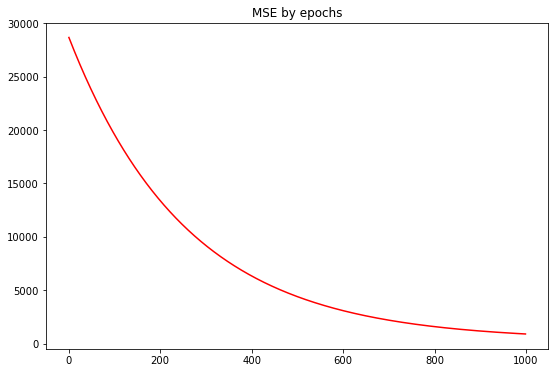

In [187]:
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True,figsize = (9,6))
gs = gridspec.GridSpec(1, 1)

ax = fig.add_subplot(gs[0, 0])
plt.plot(mse,'r')
ax.set_title('MSE by epochs')
